<a href="https://colab.research.google.com/github/maribecrurod-art/Bootstrap-Proyect/blob/main/bootstrap_flechitas_hmm_Mariana_modificado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Bootstrap + Hidden Markov Models (HMM) — Flechas 9×9



El siguiente programa permite clasificar matrices binarias de 9x9 (que representan imagenes en blanco y negro), en cuatro categorías distintas de flechas (arriba, abajo, izquierda, derecha), mediante el uso de HMM.

In [1]:
using Pkg
Pkg.add(["Plots","Images","ImageShow","Statistics"])


    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed ImageSegmentation ──────────────── v1.9.0
   Installed ImageMagick ────────────────────── v1.4.2
   Installed TiledIteration ─────────────────── v0.5.0
   Installed HistogramThresholding ──────────── v0.3.1
   Installed NearestNeighbors ───────────────── v0.4.22
   Installed RegionTrees ────────────────────── v0.3.2
   Installed LuxLib ─────────────────────────── v1.12.1
   Installed RealDot ────────────────────────── v0.1.0
   Installed Images ─────────────────────────── v0.26.2
   Installed Distances ──────────────────────── v0.10.12
   Installed MetaGraphs ─────────────────────── v0.8.1
   Installed SLEEFPirates ───────────────────── v0.6.43
   Installed JLD2 ───────────────────────────── v0.5.15
   Installed Polynomials ────────────────────── v4.1.0
   Installed LuxCore ────────────────────────── v1.4.2
   Installed ThreadingUtilities ─────────────── v0.5.5
   Installed ManualM

In [2]:
Pkg.add("ImageCore")

   Resolving package versions...
    Updating `~/.julia/environments/v1.11/Project.toml`
  [a09fc81d] + ImageCore v0.10.5
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`


In [3]:
using Random
using LinearAlgebra
using Statistics
using Plots
using Images, ImageCore



## 1) Definición de patrones:
 Se crean cuatro "imágenes" perfectas de 9x9 píxeles (matrices de 0s y 1s) que representan las cuatro direcciones de las flechas.

In [4]:
function pattern_from_strings(lines::Vector{String})
    n = length(lines)
    M = zeros(Int, n, n)
    for i in 1:n
        for j in 1:n
            M[i,j] = lines[i][j] == '1' ? 1 : 0
        end
    end
    return M
end

N = 9
up_pat = [
  "000010000",
  "000111000",
  "001010100",
  "000010000",
  "000010000",
  "000010000",
  "000010000",
  "000010000",
  "000010000"
]

up = pattern_from_strings(up_pat)
down = reverse(up, dims=1)
function rot90cw(M)
    return reverse(permutedims(M, (2,1)), dims=2)
end
function rot90ccw(M)
    return reverse(permutedims(M, (2,1)), dims=1)
end
right = rot90cw(up)
left = rot90ccw(up)

# Mostrar plantillas (texto)
for (name, M) in zip(["up","down","left","right"], [up,down,left,right])
    println("\nPlantilla: ", name)
    for i in 1:N
        println(join(string.(M[i,:]), ""))
    end
end



Plantilla: up
000010000
000111000
001010100
000010000
000010000
000010000
000010000
000010000
000010000

Plantilla: down
000010000
000010000
000010000
000010000
000010000
000010000
001010100
000111000
000010000

Plantilla: left
000000000
000000000
001000000
010000000
111111111
010000000
001000000
000000000
000000000

Plantilla: right
000000000
000000000
000000100
000000010
111111111
000000010
000000100
000000000
000000000


#2) Generación de Datos de Entrenamiento:
Se crea un conjunto de datos sintético. Toma los patrones perfectos y les añade "ruido" (invierte aleatoriamente algunos píxeles) para simular imágenes imperfectas que puedan seguir siendo clasificables.

In [5]:

function add_noise(M::Array{Int,2}; p::Float64=0.05)
    R = copy(M)
    for idx in eachindex(R)
        if rand() < p
            R[idx] = 1 - R[idx]
        end
    end
    return R
end

function mat_to_obs(M::Array{Int,2})
    v = vec(transpose(M))  # aplana por filas: fila-major
    return [x==0 ? 1 : 2 for x in v] #por lo de indexación
end

function gen_samples(pattern::Array{Int,2}, n::Int; noise::Float64=0.05)
    seqs = Vector{Vector{Int}}()
    mats = Vector{Array{Int,2}}()
    for i in 1:n
        M = add_noise(pattern, p=noise)
        push!(mats, M)
        push!(seqs, mat_to_obs(M))
    end
    return seqs, mats
end


gen_samples (generic function with 1 method)

## 3) Implementación HMM  — Forward/Backward escalado y Baum–Welch

Implementamos funciones para entrenamiento y evaluación.

Se definen las funciones forward y backward que implementan los algoritmos hacia adelante y hacia atrás. Estos algoritmos sirven para calcular probabilidades de secuencias observadas dado un modelo HMM.

También se define la función Baum–Welch que ajusta los parámetros de un HMM cuando se conocen los estados ocultos.


In [6]:
epsval() = eps(Float64) #evita errores de div por cero
function init_hmm(K::Int, M::Int)
    A = rand(K,K)
    A .= A ./ sum(A, dims=2)
    B = rand(K,M)
    B .= B ./ sum(B, dims=2)
    π = rand(K)
    π ./= sum(π)
    return A, B, π
end

#La función forward calcula la probabilidad de observar una secuencia parcial
#hasta el tiempo t, terminando en un cierto estado oculto.
function forward_scaled(O::Vector{Int}, A::Array{Float64,2}, B::Array{Float64,2}, π::Vector{Float64})
    K = size(A,1); T = length(O)
    α = zeros(Float64, K, T)
    c = zeros(Float64, T)
    for k in 1:K
        α[k,1] = π[k] * B[k, O[1]]
    end
    c[1] = sum(α[:,1])
    c[1] = c[1] == 0.0 ? epsval() : c[1]
    α[:,1] ./= c[1]
    for t in 2:T
        for k in 1:K
            α[k,t] = B[k, O[t]] * sum(α[:,t-1] .* A[:,k])
        end
        c[t] = sum(α[:,t])
        c[t] = c[t] == 0.0 ? epsval() : c[t]
        α[:,t] ./= c[t]
    end
    loglik = sum(log.(c))
    return α, c, loglik
end

#La función backward calcula la probabilidad de observar la secuencia desde t+1
#hasta el final, dado que estamos en un cierto estado en el tiempo t.
function backward_scaled(O::Vector{Int}, A::Array{Float64,2}, B::Array{Float64,2}, c::Vector{Float64})
    K = size(A,1); T = length(O)
    β = zeros(Float64, K, T)
    β[:,T] .= 1.0
    β[:,T] ./= c[T]
    for t in (T-1):-1:1
        for i in 1:K
            s = 0.0
            for j in 1:K
                s += A[i,j] * B[j, O[t+1]] * β[j, t+1]
            end
            β[i,t] = s
        end
        β[:,t] ./= c[t]
    end
    return β
end

function compute_gamma_xi(O::Vector{Int}, A::Array{Float64,2}, B::Array{Float64,2}, π::Vector{Float64})
    α, c, loglik = forward_scaled(O,A,B,π)
    β = backward_scaled(O,A,B,c)
    K = size(A,1); T = length(O)
    gamma = zeros(Float64, K, T)
    xi = zeros(Float64, K, K, max(0,T-1))
    for t in 1:T
        denom = sum(α[:,t] .* β[:,t])
        denom = denom == 0.0 ? epsval() : denom
        gamma[:,t] = (α[:,t] .* β[:,t]) ./ denom
    end
    for t in 1:T-1
        denom = 0.0
        for i in 1:K, j in 1:K
            denom += α[i,t] * A[i,j] * B[j, O[t+1]] * β[j, t+1]
        end
        denom = denom == 0.0 ? epsval() : denom
        for i in 1:K, j in 1:K
            xi[i,j,t] = α[i,t] * A[i,j] * B[j, O[t+1]] * β[j, t+1] / denom
        end
    end
    return gamma, xi, loglik
end


#estima la matriz de emisión, transición y el vector de probabilidades iniciales para maximizar
#la probabilidad de las observaciones dadas.
function baum_welch(sequences::Vector{Vector{Int}}, K::Int; M::Int=2, max_iter::Int=50, tol::Float64=1e-4)
    A, B, π = init_hmm(K, M)
    prev_ll = -Inf
    for iter in 1:max_iter
        A_num = zeros(Float64, K, K)
        A_den = zeros(Float64, K)
        B_num = zeros(Float64, K, M)
        B_den = zeros(Float64, K)
        π_acc = zeros(Float64, K)
        total_loglik = 0.0
        for O in sequences
            gamma, xi, loglik = compute_gamma_xi(O, A, B, π)
            total_loglik += loglik
            T = length(O)
            π_acc .+= gamma[:,1]
            if T > 1
                for t in 1:(T-1)
                    A_num .+= xi[:,:,t]
                    A_den .+= gamma[:,t]
                end
            end
            for t in 1:T
                for k in 1:K
                    B_num[k, O[t]] += gamma[k,t]
                    B_den[k] += gamma[k,t]
                end
            end
        end
        π = π_acc ./ sum(π_acc)
        for i in 1:K
            for j in 1:K
                A[i,j] = A_den[i] == 0.0 ? 1.0/K : A_num[i,j] / (A_den[i] + epsval())
            end
            s = sum(A[i,:])
            A[i,:] ./= (s == 0.0 ? 1.0 : s)
        end
        for k in 1:K
            for v in 1:M
                B[k,v] = B_num[k,v] / (B_den[k] + epsval())
            end
            s = sum(B[k,:])
            B[k,:] ./= (s == 0.0 ? 1.0 : s)
        end
        if iter > 1 && abs(total_loglik - prev_ll) < tol * (abs(prev_ll) + epsval())
            println("Convergencia en iteración ", iter, ", loglik = ", total_loglik)
            break
        end
        prev_ll = total_loglik
    end
    return Dict(:A=>A, :B=>B, :π=>π, :loglik=>prev_ll)
end

function model_loglik(O::Vector{Int}, model::Dict)
    _, _, loglik = forward_scaled(O, model[:A], model[:B], model[:π])
    return loglik
end


model_loglik (generic function with 1 method)

## 4) Dataset, entrenamiento y evaluación

Se genera el dataset de entrenamiento y prueba, y se entrena un HMM por clase, se usarán 160 datos, de modo que 120 sean de entrenamiento y 40 de testeo.



In [88]:
Ntrain = 600
Ntest = 100
noise = 0.04
classes = Dict(1=>up, 2=>down, 3=>left, 4=>right)
train_seqs = Dict{Int, Vector{Vector{Int}}}()
train_mats = Dict{Int, Vector{Array{Int,2}}}()
test_seqs = Dict{Int, Vector{Vector{Int}}}()
test_mats = Dict{Int, Vector{Array{Int,2}}}()
for (lab, pat) in pairs(classes)
    s, ms = gen_samples(pat, Ntrain, noise=noise)
    train_seqs[lab] = s
    train_mats[lab] = ms
    Random.seed!(1235)
    ts, tms = gen_samples(pat, Ntest, noise=noise)
    test_seqs[lab] = ts
    test_mats[lab] = tms
end
println("Dataset creado. Ejemplos por clase (train/test):")
for lab in sort(collect(keys(classes)))
    println("Clase $lab: train=$(length(train_seqs[lab])) test=$(length(test_seqs[lab]))")
end

K = 8  # estados ocultos
models = Dict{Int, Dict}()
for lab in sort(collect(keys(classes)))
    println("Entrenando clase $lab...")
    models[lab] = baum_welch(train_seqs[lab], K; M=2, max_iter=80)
    println("  loglik entreno (aprox): ", models[lab][:loglik])
end

function evaluate_models(models, test_seqs)
    total = 0; correct = 0
    perclass = Dict{Int, Tuple{Int,Int}}()
    for lab in keys(test_seqs)
        perclass[lab] = (0,0)
    end
    lablist = sort(collect(keys(models)))
    for lab in lablist
        for O in test_seqs[lab]
            scores = [model_loglik(O, models[k]) for k in lablist]
            idx = findmax(scores)[2]
            pred = lablist[idx]
            total += 1
            if pred == lab
                correct += 1
                perclass[lab] = (perclass[lab][1]+1, perclass[lab][2]+1)
            else
                perclass[lab] = (perclass[lab][1], perclass[lab][2]+1)
            end
        end
    end
    return correct/total, perclass
end

acc, perclass = evaluate_models(models, test_seqs)
println("Accuracy en test: ", round(acc*100, digits=2), "%")
for (k,v) in sort(collect(perclass))
    println("Clase $k: correct=$(v[1]) / total=$(v[2]) => ", round(100*v[1]/v[2], digits=2), "%")
end


Dataset creado. Ejemplos por clase (train/test):
Clase 1: train=600 test=100
Clase 2: train=600 test=100
Clase 3: train=600 test=100
Clase 4: train=600 test=100
Entrenando clase 1...
  loglik entreno (aprox): -22801.389488639343
Entrenando clase 2...
  loglik entreno (aprox): -22903.810914916347
Entrenando clase 3...
Convergencia en iteración 54, loglik = -17107.286640375896
  loglik entreno (aprox): -17108.87644602906
Entrenando clase 4...
Convergencia en iteración 76, loglik = -17032.581661088778
  loglik entreno (aprox): -17034.24531988564
Accuracy en test: 72.0%
Clase 1: correct=80 / total=100 => 80.0%
Clase 2: correct=24 / total=100 => 24.0%
Clase 3: correct=87 / total=100 => 87.0%
Clase 4: correct=97 / total=100 => 97.0%


In [89]:
#La siguiente parte es solo para ver como está trabajando:

function evaluate_models_confusion(models, test_seqs)
    lablist = sort(collect(keys(models)))
    nclasses = length(lablist)

    # matriz de confusión: filas = verdadera clase, columnas = predicha
    confmat = zeros(Int, nclasses, nclasses)

    total = 0
    correct = 0
    perclass = Dict{Int, Tuple{Int,Int}}()
    for lab in lablist
        perclass[lab] = (0,0)
    end

    for (i, lab) in enumerate(lablist)
        for O in test_seqs[lab]
            scores = [model_loglik(O, models[k]) for k in lablist]
            idx = findmax(scores)[2]
            pred = lablist[idx]
            j = findfirst(==(pred), lablist)  # índice de columna
            confmat[i,j] += 1
            total += 1
            if pred == lab
                correct += 1
                perclass[lab] = (perclass[lab][1]+1, perclass[lab][2]+1)
            else
                perclass[lab] = (perclass[lab][1], perclass[lab][2]+1)
            end
        end
    end

    acc = correct/total
    return acc, perclass, confmat, lablist
end
acc, perclass, confmat, lablist = evaluate_models_confusion(models, test_seqs)

println("Accuracy en test: ", round(acc*100, digits=2), "%")
for (k,v) in sort(collect(perclass))
    println("Clase $k: correct=$(v[1]) / total=$(v[2]) => ",
            round(100*v[1]/v[2], digits=2), "%")
end

println("\nMatriz de confusión (filas = verdadero, columnas = predicho):")
println("     ", join(lablist, "\t"))
for (i, lab) in enumerate(lablist)
    println("$(lab)  ", join(confmat[i,:], "\t"))
end


Accuracy en test: 72.0%
Clase 1: correct=80 / total=100 => 80.0%
Clase 2: correct=24 / total=100 => 24.0%
Clase 3: correct=87 / total=100 => 87.0%
Clase 4: correct=97 / total=100 => 97.0%

Matriz de confusión (filas = verdadero, columnas = predicho):
     1	2	3	4
1  80	20	0	0
2  76	24	0	0
3  0	2	87	11
4  0	1	2	97


Podemos ver que el modelo 2 que se encarga de clasificar las flechas hacia abajo tiene problemas, esto puede deberse a la similitud que se tiene con flechas hacia abajo, como se ve en la matriz de confusión.

## 5) Bootstrap (reentrenar sobre remuestreos del training set)
 Cada remuestreo reentrena modelos por clase
y evalúa en el conjunto de prueba fijo.


In [ ]:
B = 200
boot_accs = Float64[]
boot_perclass = Dict{Int, Vector{Float64}}()
for k in keys(classes)
    boot_perclass[k] = Float64[]
end

for b in 1:B
    # remuestreo por clase del conjunto de entrenamiento
    boot_train = Dict{Int, Vector{Vector{Int}}}()
    for (lab, seqs) in pairs(train_seqs)
        n = length(seqs)
        idxs = [rand(1:n) for _ in 1:n]
        boot_train[lab] = [seqs[i] for i in idxs]
    end
    # entrenar modelos para este bootstrap
    boot_models = Dict{Int, Dict}()
    for lab in keys(classes)
        boot_models[lab] = baum_welch(boot_train[lab], K; M=2, max_iter=40)
    end
    # evaluar
    acc_b, perclass_b = evaluate_models(boot_models, test_seqs)
    push!(boot_accs, acc_b)
    for (k,v) in perclass_b
        c, t = v
        push!(boot_perclass[k], t == 0 ? 0.0 : c / t)
    end
    if b % 20 == 0
        println("Bootstrap $b/$B  acc=$(round(acc_b*100,digits=2))%")
    end
end
println("Bootstrap completado. mean acc = ", round(mean(boot_accs)*100, digits=2), "%")


Convergencia en iteración 8, loglik = -23474.357447709066
Convergencia en iteración 14, loglik = -23354.907278049865
Convergencia en iteración 3, loglik = -23402.369392833716
Convergencia en iteración 8, loglik = -23366.89739084602
Convergencia en iteración 19, loglik = -18075.32582988422
Convergencia en iteración 11, loglik = -17898.25335653977
Convergencia en iteración 13, loglik = -23319.233163382687
Convergencia en iteración 6, loglik = -23429.718291614205
Convergencia en iteración 14, loglik = -18218.256695011787
Convergencia en iteración 12, loglik = -23453.38428666089
Convergencia en iteración 8, loglik = -23404.591896821632
Convergencia en iteración 38, loglik = -17662.8736861332
Convergencia en iteración 7, loglik = -23329.250271556462
Convergencia en iteración 6, loglik = -23382.694053765026
Convergencia en iteración 18, loglik = -18006.057983005303
Convergencia en iteración 12, loglik = -23316.039504884564
Convergencia en iteración 38, loglik = -17117.967074133274
Convergenc

## 6) Visualización y análisis

- Histograma (bootstrap)
- Intervalos de confianza percentiles


Muestra (izquierda) a visualizar:
Clase 1 -> loglik = -39.56526631294604
Clase 2 -> loglik = -38.89323062963241
Clase 3 -> loglik = -33.429764032801344
Clase 4 -> loglik = -33.468755390666715


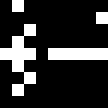

Clase 1 -> loglik = -69.78791096495215
Clase 2 -> loglik = -70.23310968419347
Clase 3 -> loglik = -70.5261787274655
Clase 4 -> loglik = -73.47590251837579


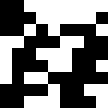

[0 1 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 1; 0 0 1 0 0 0 0 0 0; 0 1 0 0 0 0 0 0 0; 1 1 1 0 1 1 1 1 1; 0 1 0 0 0 0 0 0 0; 0 0 1 0 0 0 0 0 0; 0 1 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0]


In [16]:
#para ver como clasifica un ejemplp

function show_sample_and_scores(M::Array{Int,2}, models::Dict)
    O = mat_to_obs(M)
    scores = Dict(k => model_loglik(O, models[k]) for k in keys(models))
    # ordenar por label
    for k in sort(collect(keys(scores)))
        println("Clase $k -> loglik = ", scores[k])
    end
    # visualizar
    img = Gray.(Float64.(M))
    display(img)
end

# tomar una muestra ruidosa de 'left' y mostrar resultados
Msample = add_noise(left, p=0.06)
println("Muestra (izquierda) a visualizar:")
show_sample_and_scores(Msample, models)

show_sample_and_scores(add_noise(up, p=0.3), models)
println(Msample)

#Se elige el que tenga el valor más grande

In [17]:
Pkg.add("StatsBase")

   Resolving package versions...
    Updating `~/.julia/environments/v1.11/Project.toml`
  [2913bbd2] + StatsBase v0.34.6
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`


In [86]:
using StatsBase, Plots

# Este gráfico se mostrará directamente en la salida
histogram(boot_accs .* 100, bins=20, xlabel="Accuracy (%)", ylabel="Frecuencia", title="Distribución bootstrap de accuracy global")
savefig("hist_accuracy_global.png") # <--- LÍNEA DESACTIVADA


"/content/hist_accuracy_global.png"

In [30]:

println("IC95 global (percentiles): ", quantile(boot_accs, [0.025, 0.975]))

for k in sort(collect(keys(boot_perclass)))
    ci = quantile(boot_perclass[k], [0.025, 0.975])
    println("Clase $k IC95 (percentiles): ", ci)

    histogram(boot_perclass[k] .* 100, bins=20, xlabel="Accuracy (%)", title="Bootstrap accuracy - clase $k")

end


IC95 global (percentiles): [0.54359375, 0.72515625]
Clase 1 IC95 (percentiles): [0.025, 0.975]
Clase 2 IC95 (percentiles): [0.025, 0.9256250000000001]
Clase 3 IC95 (percentiles): [0.5737499999999999, 1.0]
Clase 4 IC95 (percentiles): [0.47437499999999994, 0.925]


In [33]:
Pkg.add("Seaborn")

   Resolving package versions...
   Installed Seaborn ────────── v1.1.1
   Installed Lazy ───────────── v0.15.1
   Installed PyPlot ─────────── v2.11.6
   Installed PyCall ─────────── v1.96.4
   Installed Pandas ─────────── v1.6.1
   Installed DataValues ─────── v0.4.13
   Installed TableTraitsUtils ─ v1.0.2
    Updating `~/.julia/environments/v1.11/Project.toml`
  [d2ef9438] + Seaborn v1.1.1
    Updating `~/.julia/environments/v1.11/Manifest.toml`
  [e7dc6d0d] + DataValues v0.4.13
  [50d2b5c4] + Lazy v0.15.1
  [eadc2687] + Pandas v1.6.1
  [438e738f] + PyCall v1.96.4
  [d330b81b] + PyPlot v2.11.6
  [d2ef9438] + Seaborn v1.1.1
  [382cd787] + TableTraitsUtils v1.0.2
    Building PyCall → `~/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/9816a3826b0ebf49ab4926e2b18842ad8b5c8f04/build.log`
Precompiling project...
   4808.0 ms  ✓ DataValues
   1557.3 ms  ✓ TableTraitsUtils
   9193.3 ms  ✓ Lazy
  29899.6 ms  ✓ PyCall
   6300.6 ms  ✓ Pandas
   7027.9 ms  ✓ PyPlot
   4843.9 ms  ✓ Se

In [40]:
using StatsBase, Statistics, Plots

function plot_bootstrap_results(samples::Vector{Float64}; ci=(2.5, 97.5),
                                title="Resultados bootstrap", xlabel="Estadístico")
    # Percentiles
    lower, upper = quantile(samples, ci[1]/100), quantile(samples, ci[2]/100)
    mean_val = mean(samples)
    median_val = median(samples)

    # Histograma + KDE
    histogram(samples, bins=30, density=true, color=:skyblue, label="Histograma", alpha=0.6)
    # Líneas
    vline!([lower, upper], color=:red, linestyle=:dash, label="IC: $(ci[1])% - $(ci[2])%")
    vline!([mean_val], color=:blue, linestyle=:solid, label="Media = $(round(mean_val,digits=3))")
    vline!([median_val], color=:green, linestyle=:dot, label="Mediana = $(round(median_val,digits=3))")

    xlabel!(xlabel)
    ylabel!("Densidad")
    title!(title)
    gui()  # abre la ventana de visualización

    println("Interpretación:")
    println("Intervalo de confianza al $(100-(100-ci[2]+ci[1]))%: [$lower, $upper]")
    println("Media: $mean_val, Mediana: $median_val")
end


plot_bootstrap_results (generic function with 1 method)

In [41]:
using Statistics, StatsBase, Plots, Markdown

function plot_bootstrap_convergence(samples::Vector{Float64}; ci=(2.5,97.5),
                                    title="Convergencia del bootstrap", xlabel="Réplicas")
    means, lowers, uppers = Float64[], Float64[], Float64[]
    n = length(samples)

    # Tomamos submuestras crecientes
    for i in 10: max(1, n ÷ 100): n
        subset = samples[1:i]
        push!(means, mean(subset))
        push!(lowers, quantile(subset, ci[1]/100))
        push!(uppers, quantile(subset, ci[2]/100))
    end

    x = 10: max(1, n ÷ 100): n
    plot(x, means, label="Media", lw=2)
    plot!(x, lowers, ribbon=(uppers.-lowers), color=:skyblue, alpha=0.4, label="IC $(ci[1])%-$(ci[2])%")
    title!(title)
    xlabel!(xlabel)
    ylabel!("Valor del estadístico")
    gui()  # muestra la gráfica

    display(Markdown("**Interpretación:** La gráfica muestra cómo se estabiliza la media y los intervalos de confianza al aumentar el número de réplicas bootstrap."))
end


plot_bootstrap_convergence (generic function with 1 method)

In [56]:
using Random, Statistics, StatsBase, Plots, Distributions, Markdown

function plot_bootstrap_results(samples::Vector{Float64}; ci=(2.5,97.5),
                                title="Resultados bootstrap", xlabel="Estadístico")
    # Percentiles
    lower = quantile(samples, ci[1]/100)
    upper = quantile(samples, ci[2]/100)
    mean_val = mean(samples)
    median_val = median(samples)

    # Histograma + líneas de referencia
    histogram(samples, bins=30, density=true, color=:skyblue, alpha=0.6, label="Histograma")
    vline!([lower, upper], color=:red, linestyle=:dash, label="IC $(ci[1])%-$(ci[2])%")
    vline!([mean_val], color=:blue, linestyle=:solid, label="Media = $(round(mean_val,digits=3))")
    vline!([median_val], color=:green, linestyle=:dot, label="Mediana = $(round(median_val,digits=3))")

    xlabel!(xlabel)
    ylabel!("Densidad")
    title!(title)

    # Interpretación en Markdown
    display(Markdown("**Interpretación:** IC al $(ci[1])%-$(ci[2])%: [$lower, $upper]. Media = $mean_val, Mediana = $median_val"))
end

# =================================
function plot_bootstrap_convergence(samples::Vector{Float64}; ci=(2.5,97.5),
                                    title="Convergencia del bootstrap", xlabel="Réplicas")
    means, lowers, uppers = Float64[], Float64[], Float64[]
    n = length(samples)

    step = max(1, n ÷ 100)  # tomamos 100 puntos aprox
    for i in 10:step:n
        subset = samples[1:i]
        push!(means, mean(subset))
        push!(lowers, quantile(subset, ci[1]/100))
        push!(uppers, quantile(subset, ci[2]/100))
    end

    x = collect(10:step:n)
    plot(x, means, label="Media", lw=2)
    plot!(x, means, ribbon=(uppers.-means), color=:skyblue, alpha=0.4, label="IC $(ci[1])%-$(ci[2])%")
    title!(title)
    xlabel!(xlabel)
    ylabel!("Valor del estadístico")

    display(Markdown("**Interpretación:** La gráfica muestra cómo se estabiliza la media y los intervalos de confianza al aumentar el número de réplicas bootstrap."))
end



plot_bootstrap_convergence (generic function with 1 method)

In [43]:

Pkg.add("Distributions")

   Resolving package versions...
    Updating `~/.julia/environments/v1.11/Project.toml`
  [31c24e10] + Distributions v0.25.120
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
